## BB-KI-CHIPS project 

Technical Univestiy of Munich, Big Geospatial Data 

In [101]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target
import shap
import tensorflow as tf

In [3]:
# define the functions you need

def loadimg(filename):
    # Open a single band and plot
    with rasterio.open(filename) as src:
        a = src.read()
        nbands = src.count
        nrows = src.height
        ncolumns = src.width
    image = np.empty([nrows, ncolumns, nbands])
    for i in range(nbands):
        image[:, :, i] = a[i, :, :]
    return image

## this function define how you split the raw image, in the example below is 64
def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)

def visualize_patches(dir_tile, size):
    all_tiles=os.listdir(dir_tile)
    image_path = [os.path.join(dir_tile + "/" + i) for i in all_tiles]
    k=0
    total_num = size*size 
    for i in image_path[0:total_num]:
      k=k+1
      plt.subplot(size, size, k) 
      plt.imshow(imread(i))
      plt.axis('off')
    plt.show()

def std_image(src, eps=0.1):
    x_max = src.max()
    x_min = src.min()
    if x_max - x_min > eps:
        return 2 * ((src - x_min) / (x_max - x_min)) - 1
    return src    
    
def navie_sample(src_image, label):
    # forest-1, debris-2, water-3
    classes = label
    # get the feature space from drone image
    with rasterio.open(src_image) as src_ds:
        src = src_ds.read()
        std_src = std_image(src)
        yield (std_src, label)


# Input the drone data

['/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0708.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0682.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0684.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0686.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0700.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/DJI_0702.JPG', '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/B

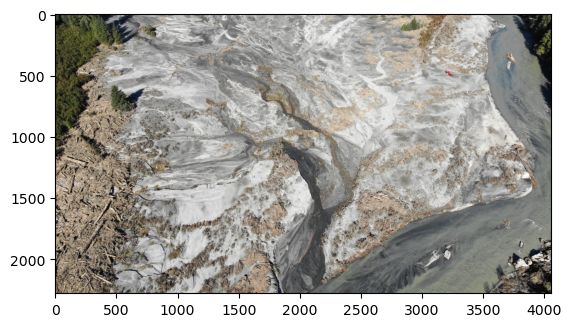

In [4]:
###########  Data Import #############

##You can also define your own path/name here
dir_image = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data"



dir_image_JPG = dir_image + "/*.JPG"
raw_images = glob.glob(dir_image_JPG)
print(raw_images)

filenames = [os.path.basename(x) for x in glob.glob(dir_image_JPG)]

print(filenames)


###########  Visualize the first image #############
## Here you can show the image you are processing by changing the numbers 0,1,2,3 etc.
img = mpimg.imread(raw_images[1])
imgplot = plt.imshow(img)
plt.show()


## Preprocessing data step 1 - Tile the image

In [5]:
########### Tile image to pataches #############
dir_tile = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/tiles"
# define the patch size,this way you would have 64*64 tiles. This can be changed at the -tile- funciton.
patch_size = 64

image = loadimg(raw_images[0])
pixel_x, pixel_y, bands= image.shape
print("Raw Images are of: " + str(pixel_x) + " x " + str(pixel_y) +" pixels")

tile(filenames[0], dir_image, dir_tile, patch_size)
print("Image tiling is now successful!")


Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


Raw Images are of: 2280 x 4056 pixels
Image tiling is now successful!


### Labelling - step 1.5: if you want to directly try to work with the labelled data you can start from step 2


# Here the Labelling happens!! One should follow these steps:
--------------

### 1. Open the folder and check how many tiles are there: ./Ecstall_drone_data/Ecstall_drone_data/tiles

### 2. Check if there are three different sub-folders for classes:
    #### * debris
    #### * forest
    #### * water

### 3. Identify the corrrect classes for tiles and move them into the right sub-folder;

--------------

# As a results, each sub-folder should contains the right tiles for this classes.


## Preprocessing data step 2 - Visualize & sort the labelled data

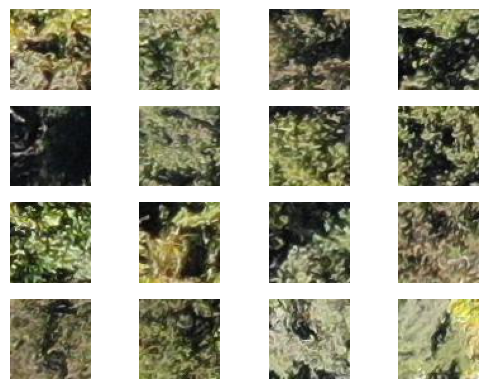

Example patches for forest


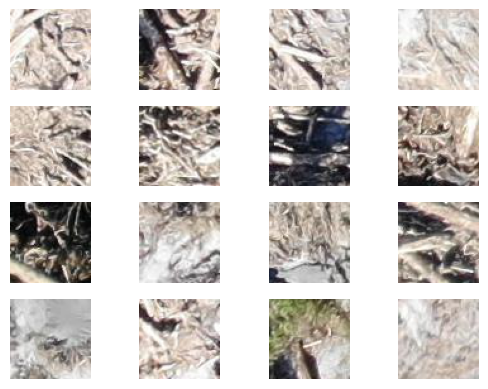

Example patches for debris


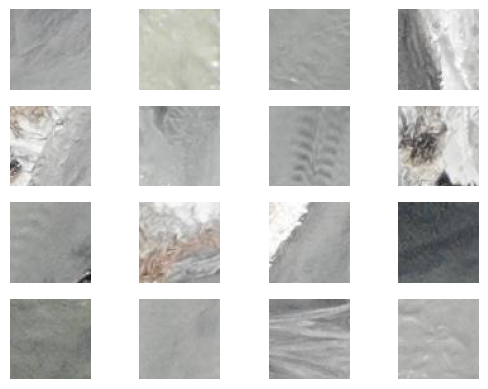

Example patches for water


In [6]:
########### Visualize 6x6 pataches for different classes #############
dir_tile = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/tiles"
# with how many tile per row/colunm one want to visualize
# Here with the spcific example 0682, the white landcover mostly also been counted into the water class
visualize_size =  4
patch_size = 64
input_size=[64,64,3]
output_size=3
# class forest
dir_tile_forest = dir_tile + "/forest"
visualize_patches(dir_tile_forest, visualize_size)
print('Example patches for forest')

# class debris
dir_tile_debris = dir_tile + "/debris"
visualize_patches(dir_tile_debris, visualize_size)
print('Example patches for debris')

# class water

dir_tile_water = dir_tile + "/water"
visualize_patches(dir_tile_water, visualize_size)
print('Example patches for water')



## Preprocessing data step 3 - Store Image+Label for ML training 

In [11]:
########### define the result train/valid file #############
### Here the tiles are then saved into numpy arraies
root = r"/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Big_Geospatial_Data/BBKI_drone_debris_detection/Ecstall_drone_data/Ecstall_drone_data/train_sample/"

# training samples
t_forest = root + "forest_train_samples.npy"
t_debris = root + "debris_train_samples.npy"
t_water = root + "water_train_samples.npy"


# forest-1, save into numpy 
forest_tiles=os.listdir(dir_tile_forest)
t_sample = []
for p in tqdm(forest_tiles):
    image_path = dir_tile_forest + '/' + p
    result = list(navie_sample(image_path, 1))
    t_sample.append(result)
t_sample_array = np.array(t_sample, dtype=object)
#print(t_sample_array)
np.save(t_forest, t_sample_array)


# debris-2, save into numpy (someone need to rewrite it with a loop)
debris_tiles=os.listdir(dir_tile_debris)
t_sample = []
for p in tqdm(debris_tiles):
    image_path = dir_tile_debris + '/' + p
    result = list(navie_sample(image_path, 2))
    t_sample.append(result)
t_sample_array = np.array(t_sample, dtype=object)
#print(t_sample_array)
np.save(t_debris, t_sample_array)


# water-3, save into numpy 
water_tiles=os.listdir(dir_tile_water)
t_sample = []
for p in tqdm(water_tiles):
    image_path = dir_tile_water + '/' + p
    result = list(navie_sample(image_path, 3))
    t_sample.append(result)
t_sample_array = np.array(t_sample, dtype=object)
#print(t_sample_array)
np.save(t_water, t_sample_array)


#print("All training data is saved into: " + root)


    

100%|██████████| 3705/3705 [00:05<00:00, 668.17it/s]


## Preprocessing data step 4 - Split into train and val

In [12]:
# get all npy files
## The ratio can also be changed
split_ratio = 0.8
dir_samples = root + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = root + "/train_merge.npy"
v_samples_merge_path = root + "/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

2it [00:00,  4.80it/s]


Now all merge samples are saved!


In [13]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)


(10600, 1, 2)
(2651, 1, 2)


In [14]:
train_merge=np.array(train_merge)

print(train_merge[0,0,1])
print(train_merge[0,0,0].shape)

output_size=3

3
(3, 64, 64)


In [15]:
output_size=4

## Preprocessing data step 5 -  Random Forest Classifier

Machine learning: A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T, as measured by P, improves with experience E (*Tom M. Michell, 1997*).


A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.



In [16]:
# The random forest expects a vector of features. Therefore,
# we concatenate all bands and pixels
UAV_train = train_merge[:,:,0]
number_samples = UAV_train.shape[0]
Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)


X_train= np.zeros((number_samples,  3 * 64 * 64), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = np.reshape(UAV_train[i,0], (1, 3 * 64 * 64))
    

print("Post-processed UAV data shape: ", X_train.shape)
print("Post-processed class type data shape: ", Y_train.shape)


Post-processed UAV data shape:  (10600, 12288)
Post-processed class type data shape:  (10600,)


In [17]:
UAV_val = val_merge[:,:,0]

number_samples = UAV_val.shape[0]
Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

X_val= np.zeros((number_samples,  3 * 64 * 64), dtype=float)
for i in range(0,number_samples-1):
    X_val[i,:] = np.reshape(UAV_val[i,0], (1, 3 * 64 * 64))
    

print("Post-processed UAV data shape: ", X_val.shape)
print("Post-processed class type data shape: ", Y_val.shape)

Post-processed UAV data shape:  (2651, 12288)
Post-processed class type data shape:  (2651,)


In [18]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [19]:
y_pred_rf = rf_classifier.predict(X_val)

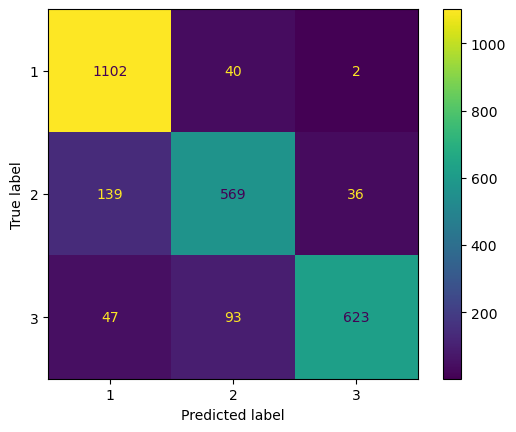

Accuracy Random Forest Classifier:  0.8653338362881932


In [20]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

In [21]:
base_model =tf.keras.applications.MobileNetV2(
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,input_shape=input_size, pooling=None, classes=output_size)
   
    

base_model.trainable = False
base_learning_rate = 0.0001

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-20 11:08:07.800309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 11:08:07.801327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=20,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping3=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)

## Preprocessing data step 6 -  Deep learning: Artificial neural network

The human brain is a *machine* capable of performing very complex tasks, such as pattern recognition, motor control of a limb or perception of sensory stimuli, much faster than any machine invented by man. For this reason, great efforts have been (and continue to be) made to understand how they work. 

Machine learning: A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T, as measured by P, improves with experience E (*Tom M. Michell, 1997*).


In [103]:
number_samples = UAV_train.shape[0]
Z_train= np.zeros((number_samples,  3 , 64 ,64), dtype=float)
for i in range(0,number_samples-1):
    Z_train[i,:] = UAV_train[i,0]
    

print("Post-processed UAV data shape: ", Z_train.shape)
print("Post-processed class type data shape: ", Y_train.shape)

Post-processed UAV data shape:  (10600, 3, 64, 64)
Post-processed class type data shape:  (10600,)


In [24]:
number_samples = UAV_val.shape[0]
Z_val= np.zeros((number_samples,  3 , 64 ,64), dtype=float)
for i in range(0,number_samples-1):
    Z_val[i,:] = UAV_val[i,0]
    

print("Post-processed UAV data shape: ", Z_val.shape)
print("Post-processed class type data shape: ", Y_val.shape)

Post-processed UAV data shape:  (2651, 3, 64, 64)
Post-processed class type data shape:  (2651,)


In [25]:
number_samples = UAV_train.shape[0]
R_trai= np.zeros((number_samples, 3, 64 ,64), dtype=float)
R_train= np.zeros((number_samples,  64 ,64,3), dtype=float)

for i in range(0,number_samples-1):
    R_trai[i,:] = UAV_train[i,0]
    R_train[i,:] = np.stack((R_trai[i,0,:],R_trai[i,1,:],R_trai[i,2,:]),axis=2)
    
print("Post-processed UAV data shape: ", R_train.shape)
print("Post-processed class type data shape: ", Y_train.shape)

Post-processed UAV data shape:  (10600, 64, 64, 3)
Post-processed class type data shape:  (10600,)


In [26]:
number_samples = UAV_val.shape[0]
R_va= np.zeros((number_samples, 3, 64 ,64), dtype=float)
R_val= np.zeros((number_samples,  64 ,64,3), dtype=float)

for i in range(0,number_samples-1):
    R_va[i,:] = UAV_val[i,0]
    R_val[i,:] = np.stack((R_va[i,0,:],R_va[i,1,:],R_va[i,2,:]),axis=2)
   
print("Post-processed UAV data shape: ", R_val.shape)
print("Post-processed class type data shape: ", Y_val.shape)

Post-processed UAV data shape:  (2651, 64, 64, 3)
Post-processed class type data shape:  (2651,)


In [38]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3, 64, 64)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [40]:
history=simple_model.fit(Z_train, Y_train, epochs=200,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,validation_data=(Z_val, Y_val))


Epoch 1/200


2023-02-20 11:13:59.511517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-20 11:14:02.132851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 3s 10ms/sample - loss: 1.0448 - accuracy: 0.7779 - val_loss: 0.6616 - val_accuracy: 0.8114
Epoch 21/200
332/332 [==============================] - 3s 8ms/sample - loss: 0.1457 - accuracy: 0.9555 - val_loss: 0.3382 - val_accuracy: 0.8982


42/83 [==============>...............] - ETA: 0s

2023-02-20 11:15:43.364005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 0s 4ms/step


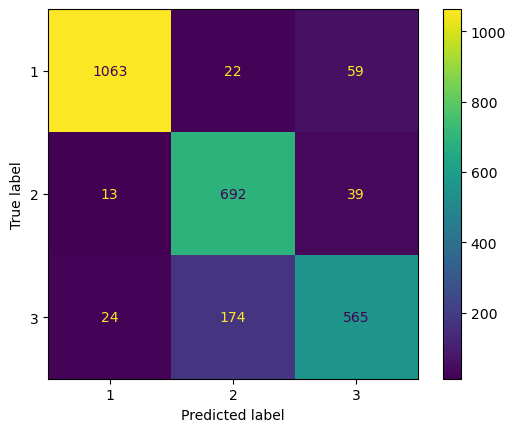

Accuracy Simple Deep Learning model:  0.8751414560543191


In [41]:
y_pred_dl_p = simple_model.predict(Z_val)
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

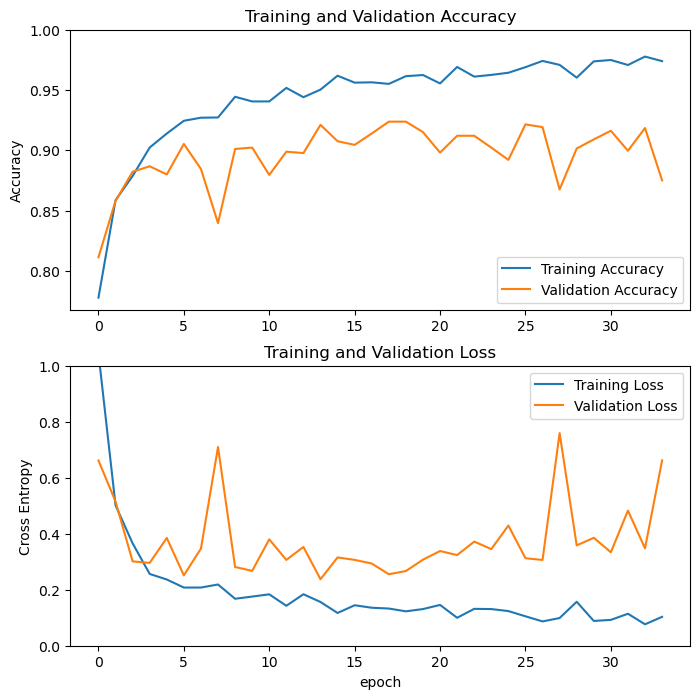

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

simple_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
simple_model.summary()
len(simple_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1572992   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,573,508
Trainable params: 1,573,508
Non-trainable params: 0
_________________________________________________________________


4

In [44]:
fine_tune_epochs = 20
initial_epochs = max(history.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(Z_train,Y_train,
                         epochs=total_epochs,callbacks=[EarlyStopping2],
                         initial_epoch=history.epoch[-1],
                         validation_data=(Z_val,Y_val))

Epoch 34/53


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
2023-02-20 11:15:53.270178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9800

2023-02-20 11:15:56.774605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 4s 12ms/step - loss: 0.0778 - accuracy: 0.9800 - val_loss: 0.3060 - val_accuracy: 0.9283
Epoch 35/53
332/332 [==============================] - 4s 11ms/step - loss: 0.0357 - accuracy: 0.9910 - val_loss: 0.3039 - val_accuracy: 0.9302
Epoch 36/53
332/332 [==============================] - 4s 11ms/step - loss: 0.0303 - accuracy: 0.9925 - val_loss: 0.3007 - val_accuracy: 0.9310
Epoch 37/53
332/332 [==============================] - 3s 10ms/step - loss: 0.0277 - accuracy: 0.9927 - val_loss: 0.3038 - val_accuracy: 0.9302
Epoch 38/53
332/332 [==============================] - 4s 11ms/step - loss: 0.0251 - accuracy: 0.9936 - val_loss: 0.3026 - val_accuracy: 0.9306
Epoch 39/53
332/332 [==============================] - 4s 11ms/step - loss: 0.0255 - accuracy: 0.9938 - val_loss: 0.2982 - val_accuracy: 0.9317
Epoch 40/53
332/332 [==============================] - 4s 11ms/step - loss: 0.0253 - accuracy: 0.9942 - val_loss: 0.2995 - val_accuracy: 0.9302
Epoc

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

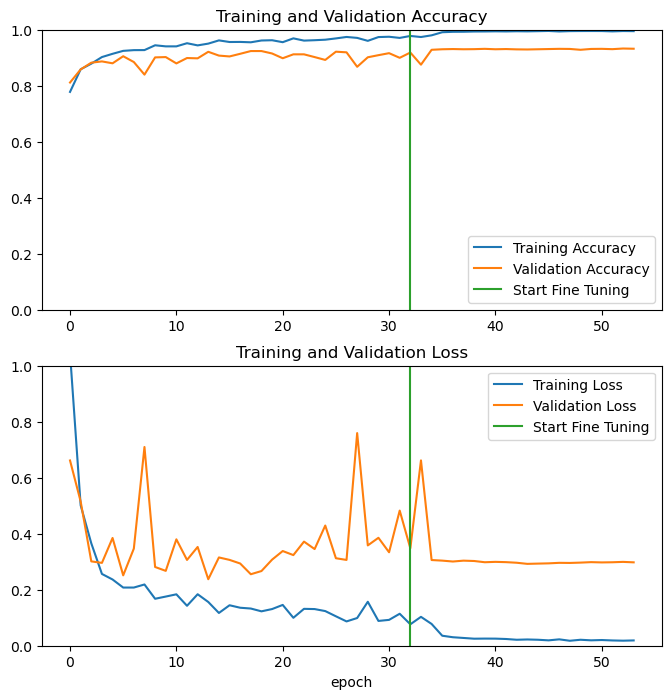

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Preprocessing data step 7 - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.


In [50]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_size, 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

# Uncomment the following line to check the full model
# model_rn.summary()

In [51]:

history2=model_rn.fit(R_train, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,validation_data=(R_val, Y_val))


Epoch 1/100


2023-02-20 11:21:40.947211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-20 11:22:14.939534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 40s 120ms/sample - loss: 0.4612 - accuracy: 0.8781 - val_loss: 0.8894 - val_accuracy: 0.7107
Epoch 21/100
332/332 [==============================] - 32s 95ms/sample - loss: 0.1379 - accuracy: 0.9525 - val_loss: 0.1985 - val_accuracy: 0.9732


2023-02-20 11:38:42.316706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 4s 30ms/step


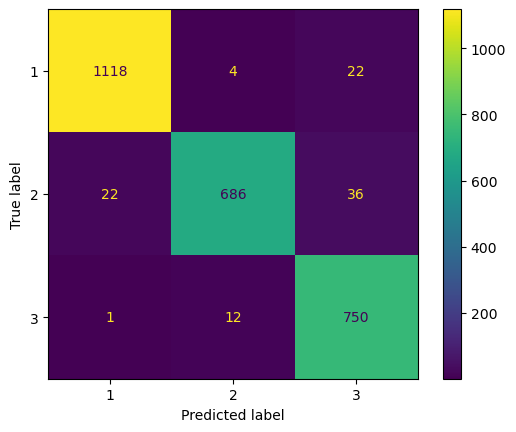

Accuracy ResNet-50 model:  0.963410033949453


In [52]:
y_pred_rn_p = model_rn.predict(R_val)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

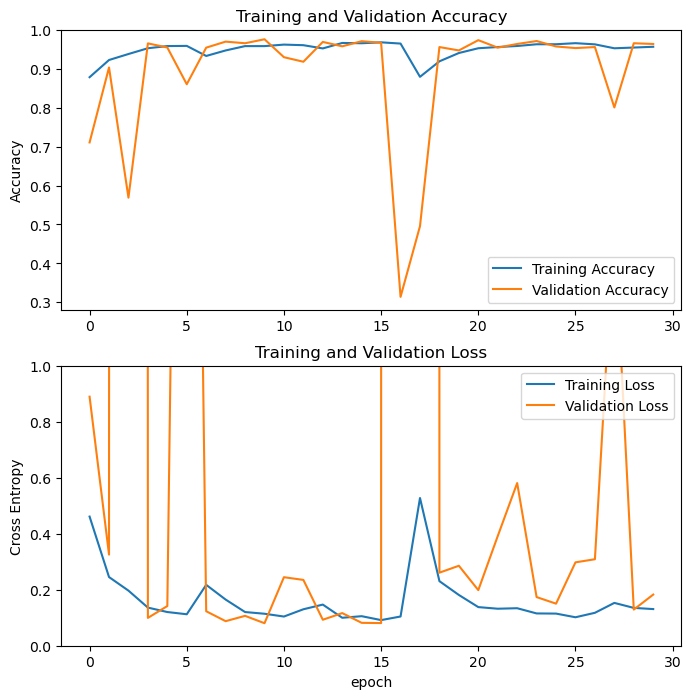

In [53]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [118]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_rn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model_rn.summary()
len(model_rn.trainable_variables)

Number of layers in the base model:  154
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                  

214

In [119]:
fine_tune_epochs = 20
initial_epochs = max(history2.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_rn.fit(R_train,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping3,
                         initial_epoch=history2.epoch[-1],
                         validation_data=(R_val,Y_val))

Epoch 30/49


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
2023-02-20 18:53:52.461631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9686

2023-02-20 18:55:17.772269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 96s 191ms/step - loss: 0.0923 - accuracy: 0.9686 - val_loss: 0.1309 - val_accuracy: 0.9751
Epoch 31/49
332/332 [==============================] - 54s 163ms/step - loss: 0.0835 - accuracy: 0.9705 - val_loss: 0.1292 - val_accuracy: 0.9755
Epoch 32/49
332/332 [==============================] - 52s 158ms/step - loss: 0.0814 - accuracy: 0.9718 - val_loss: 0.1270 - val_accuracy: 0.9755
Epoch 33/49
332/332 [==============================] - 52s 158ms/step - loss: 0.0833 - accuracy: 0.9713 - val_loss: 0.1302 - val_accuracy: 0.9755
Epoch 34/49
332/332 [==============================] - 51s 155ms/step - loss: 0.0783 - accuracy: 0.9731 - val_loss: 0.1319 - val_accuracy: 0.9759
Epoch 35/49
332/332 [==============================] - 51s 153ms/step - loss: 0.0822 - accuracy: 0.9726 - val_loss: 0.1330 - val_accuracy: 0.9755


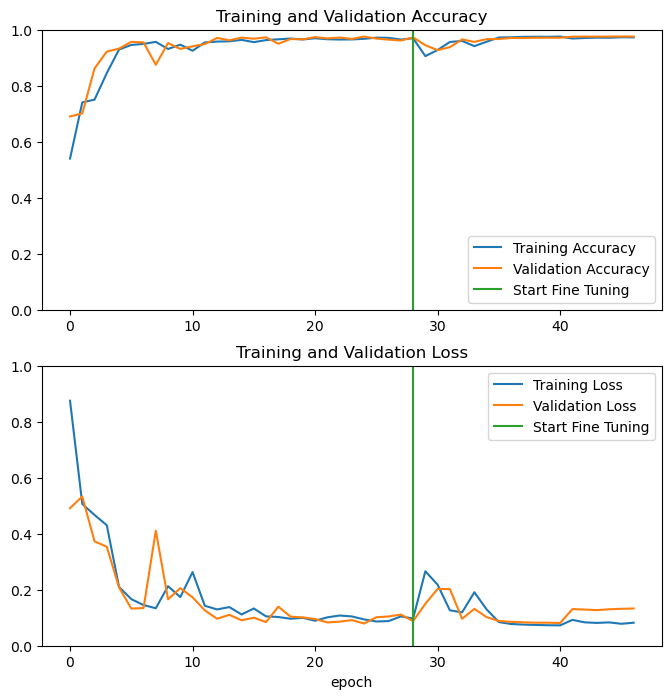

In [120]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Preprocessing data step 8 - Convolutional Network: CNN

In [57]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu",input_shape=input_size),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
]
)

In [58]:

CNNs_model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [59]:

CNNs_model.add(tf.keras.layers.Flatten())
CNNs_model.add(tf.keras.layers.Dense(64, activation='relu'))
CNNs_model.add(tf.keras.layers.Dense(output_size))

In [60]:
CNNs_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [61]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history3 = CNNs_model.fit(R_train, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,
                    validation_data=(R_val, Y_val))

Epoch 1/100


2023-02-20 11:42:53.099712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-20 11:43:02.515496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 11s 33ms/sample - loss: 0.2804 - accuracy: 0.8852 - val_loss: 0.1784 - val_accuracy: 0.9317
Epoch 21/100
332/332 [==============================] - 7s 22ms/sample - loss: 0.0117 - accuracy: 0.9945 - val_loss: 0.1769 - val_accuracy: 0.9623


In [62]:
y_pred_cnn_p = CNNs_model.predict(R_val)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

 3/83 [>.............................] - ETA: 2s 

2023-02-20 11:58:49.322797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 1s 10ms/step
Prediction example:  [-21.997223   10.7992325  -3.424489   -4.227663 ]  Class:  1


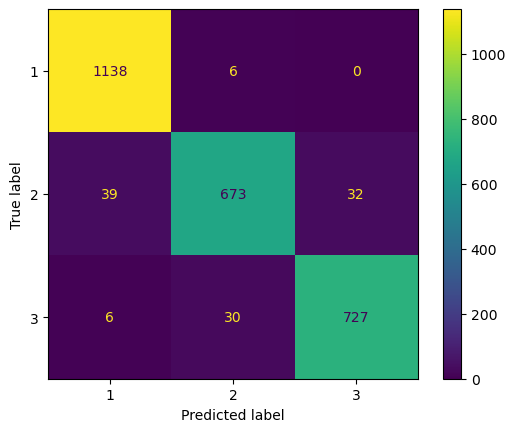

Accuracy Simple Deep Learning model:  0.957374575631837


In [63]:
y_pred_cnn = np.array(np.argmax(y_pred_cnn_p, axis=1)).astype(int)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

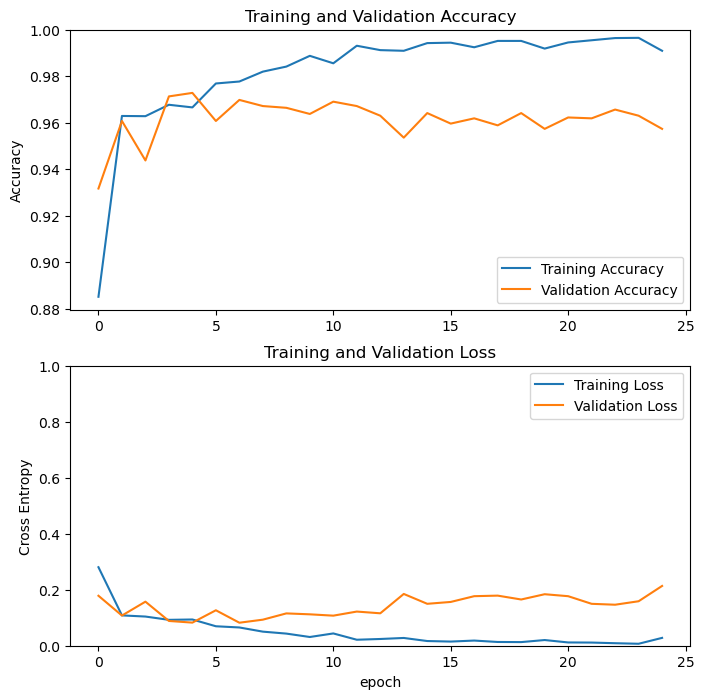

In [64]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [65]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

CNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
CNNs_model.summary()
len(CNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Den

12

In [66]:

fine_tune_epochs = 20
initial_epochs = max(history3.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = CNNs_model.fit(R_train,Y_train,
                         epochs=total_epochs,callbacks=EarlyStopping3,
                         initial_epoch=history3.epoch[-1],
                         validation_data=(R_val,Y_val))

Epoch 25/44


2023-02-20 11:59:01.835444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9958

2023-02-20 11:59:12.281516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 12s 31ms/step - loss: 0.0112 - accuracy: 0.9958 - val_loss: 0.1959 - val_accuracy: 0.9615
Epoch 26/44
332/332 [==============================] - 9s 28ms/step - loss: 0.0083 - accuracy: 0.9965 - val_loss: 0.1936 - val_accuracy: 0.9630
Epoch 27/44
332/332 [==============================] - 9s 28ms/step - loss: 0.0072 - accuracy: 0.9969 - val_loss: 0.1956 - val_accuracy: 0.9627
Epoch 28/44
332/332 [==============================] - 9s 28ms/step - loss: 0.0065 - accuracy: 0.9969 - val_loss: 0.1988 - val_accuracy: 0.9627
Epoch 29/44
332/332 [==============================] - 9s 28ms/step - loss: 0.0061 - accuracy: 0.9970 - val_loss: 0.2025 - val_accuracy: 0.9630
Epoch 30/44
332/332 [==============================] - 9s 28ms/step - loss: 0.0059 - accuracy: 0.9972 - val_loss: 0.2066 - val_accuracy: 0.9623


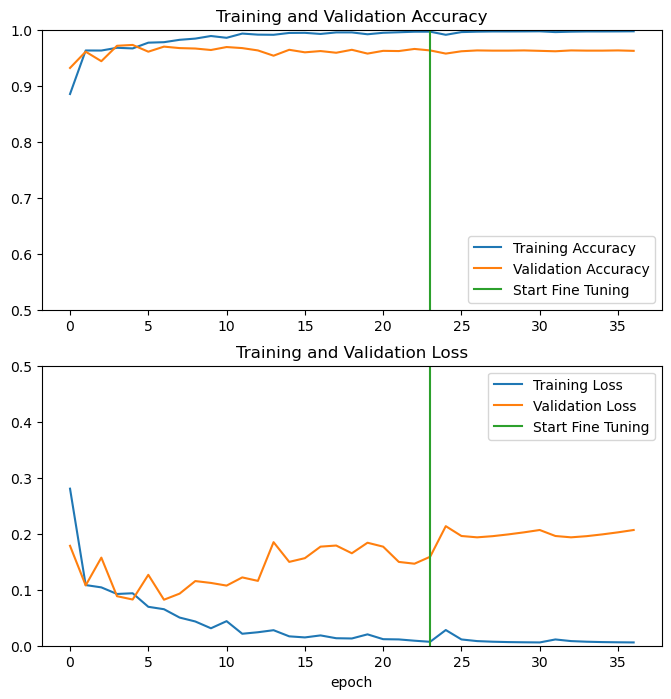

In [68]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Preprocessing data step 9 - MobileNet training



In [78]:

inputs = tf.keras.layers.Input(shape=input_size, name="input_image")
MobileNetV2_model = tf.keras.applications.MobileNet( input_tensor=inputs,
                                               include_top=True,
                                               input_shape=input_size, 
                                               weights=None,#'imagenet',
                                               classes=output_size,
                                               pooling=None)

In [79]:
#base_learning_rate = 0.0001
#MobileNetV2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
 #             metrics=['accuracy'])

MobileNetV2_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
MobileNetV2_model.summary()


Model: "mobilenet_1.00_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                          

In [80]:

history4 = MobileNetV2_model.fit(R_train, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,
                    validation_data=(R_val, Y_val))

Epoch 1/100


2023-02-20 17:39:01.595977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-20 17:39:18.447364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 21s 62ms/sample - loss: 0.4381 - accuracy: 0.8373 - val_loss: 1.1389 - val_accuracy: 0.4315
Epoch 21/100
332/332 [==============================] - 13s 41ms/sample - loss: 0.0613 - accuracy: 0.9798 - val_loss: 0.1634 - val_accuracy: 0.9498


In [81]:
y_pred_mbn_p = MobileNetV2_model.predict(R_val)

print("Prediction example: ", y_pred_mbn_p[0,:], " Class: ", np.argmax(y_pred_mbn_p[0,:]))

2023-02-20 17:50:35.639497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 2s 19ms/step
Prediction example:  [4.2100241e-06 9.0648013e-01 7.6700881e-02 1.6814835e-02]  Class:  1


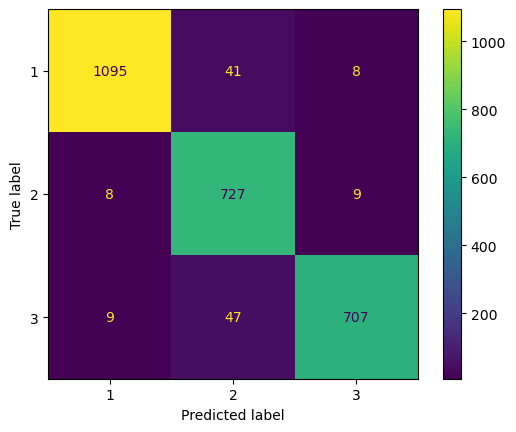

Accuracy Simple Deep Learning model:  0.953979630328178


In [82]:
y_pred_mbn = np.array(np.argmax(y_pred_mbn_p, axis=1)).astype(int)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_mbn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_mbn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

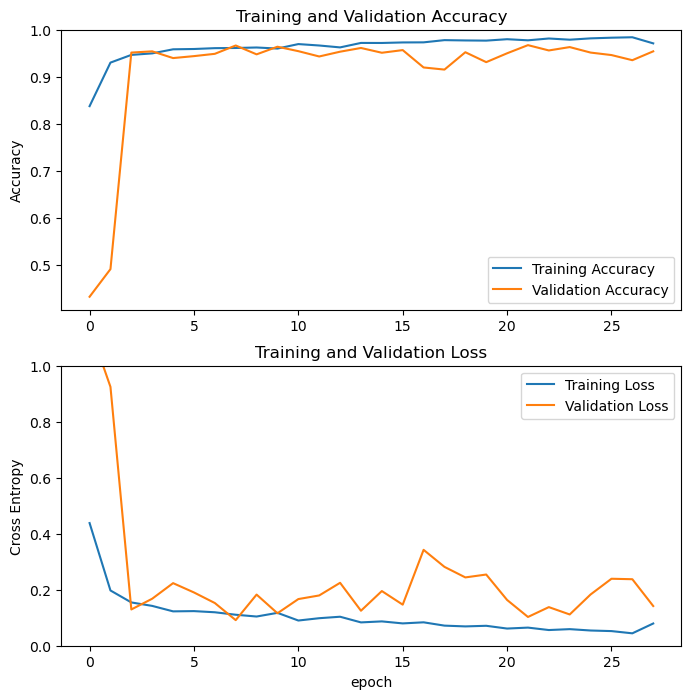

In [83]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [84]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

MobileNetV2_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
MobileNetV2_model.summary()
len(MobileNetV2_model.trainable_variables)

Number of layers in the base model:  154
Model: "mobilenet_1.00_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation) 

83

In [85]:

fine_tune_epochs = 20
initial_epochs = max(history4.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = MobileNetV2_model.fit(R_train,Y_train,
                         epochs=total_epochs,callbacks=EarlyStopping3,
                         initial_epoch=history4.epoch[-1],
                         validation_data=(R_val,Y_val))

Epoch 28/47


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
2023-02-20 17:51:01.553188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9896

2023-02-20 17:51:32.236481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 34s 81ms/step - loss: 0.0325 - accuracy: 0.9896 - val_loss: 0.0948 - val_accuracy: 0.9698
Epoch 29/47
332/332 [==============================] - 23s 70ms/step - loss: 0.0261 - accuracy: 0.9913 - val_loss: 0.0959 - val_accuracy: 0.9713
Epoch 30/47
332/332 [==============================] - 23s 69ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0983 - val_accuracy: 0.9717
Epoch 31/47
332/332 [==============================] - 23s 69ms/step - loss: 0.0222 - accuracy: 0.9929 - val_loss: 0.1014 - val_accuracy: 0.9721
Epoch 32/47
332/332 [==============================] - 22s 67ms/step - loss: 0.0221 - accuracy: 0.9934 - val_loss: 0.1020 - val_accuracy: 0.9725
Epoch 33/47
332/332 [==============================] - 23s 70ms/step - loss: 0.0206 - accuracy: 0.9929 - val_loss: 0.1047 - val_accuracy: 0.9725


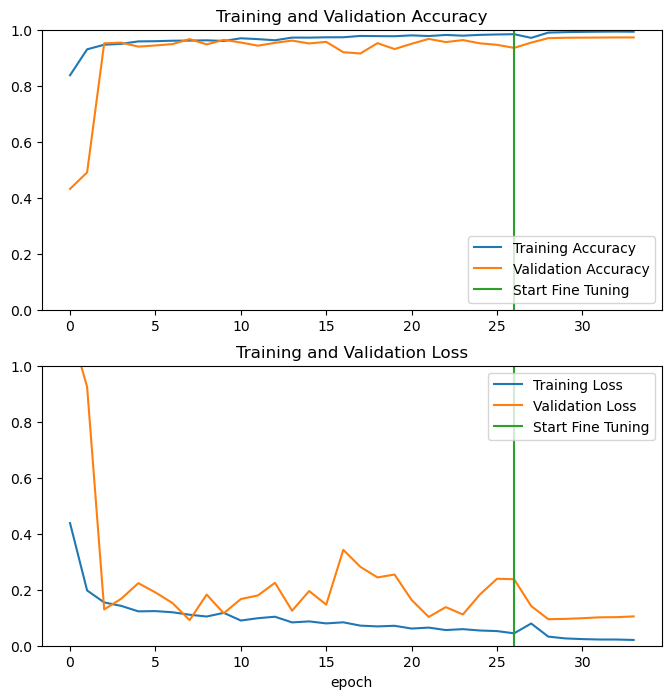

In [86]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Preprocessing data step 10 - VGG16 Network training

In [87]:
VGG16 = tf.keras.applications.VGG16( input_tensor=inputs,
                                               include_top=True,
                                               input_shape=input_size, 
                                               weights=None,#'imagenet',
                                               classes=output_size,
                                               pooling=None)

In [88]:
VGG16.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [89]:
history6 = VGG16.fit(R_train, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping2],  verbose=0,
                   validation_data=(R_val, Y_val))

Epoch 1/100


2023-02-20 17:54:51.155003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-20 17:55:31.376456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 44s 133ms/sample - loss: 0.8749 - accuracy: 0.5397 - val_loss: 0.4913 - val_accuracy: 0.6903
Epoch 21/100
332/332 [==============================] - 39s 117ms/sample - loss: 0.0893 - accuracy: 0.9695 - val_loss: 0.0953 - val_accuracy: 0.9736


In [90]:
y_pred_vgg_p = VGG16.predict(R_val)
print("Prediction example: ", y_pred_vgg_p[0,:], " Class: ", np.argmax(y_pred_vgg_p[0,:]))

2023-02-20 18:22:02.276789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 4s 37ms/step
Prediction example:  [1.4243914e-08 9.2235130e-01 4.6116967e-02 3.1531762e-02]  Class:  1


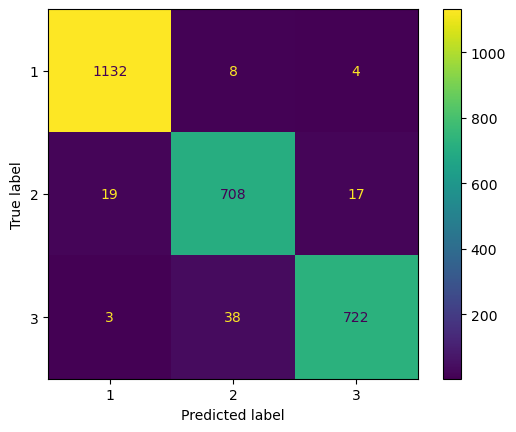

Accuracy Simple Deep Learning model:  0.9664277631082611


In [91]:
y_pred_vgg = np.array(np.argmax(y_pred_vgg_p, axis=1)).astype(int)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_vgg)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_vgg)
print("Accuracy Simple Deep Learning model: ", acc_dl)

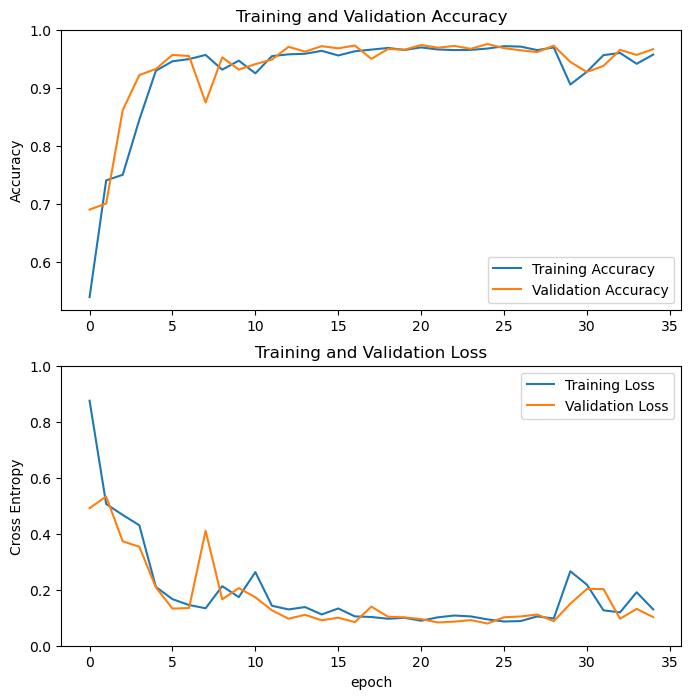

In [92]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [108]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

VGG16.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
VGG16.summary()
len(VGG16.trainable_variables)

Number of layers in the base model:  154
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPoo

32

In [109]:

fine_tune_epochs = 20
initial_epochs = max(history6.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = VGG16.fit(R_train,Y_train,
                         epochs=total_epochs,callbacks=EarlyStopping3,
                         initial_epoch=history6.epoch[-1],
                         validation_data=(R_val,Y_val))

Epoch 35/54


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
2023-02-20 18:40:53.783361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9723

2023-02-20 18:41:41.611011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


332/332 [==============================] - 52s 142ms/step - loss: 0.0844 - accuracy: 0.9723 - val_loss: 0.0883 - val_accuracy: 0.9668
Epoch 36/54
332/332 [==============================] - 43s 128ms/step - loss: 0.0776 - accuracy: 0.9730 - val_loss: 0.0852 - val_accuracy: 0.9706
Epoch 37/54
332/332 [==============================] - 43s 130ms/step - loss: 0.0754 - accuracy: 0.9745 - val_loss: 0.0837 - val_accuracy: 0.9702
Epoch 38/54
332/332 [==============================] - 43s 129ms/step - loss: 0.0742 - accuracy: 0.9750 - val_loss: 0.0822 - val_accuracy: 0.9713
Epoch 39/54
332/332 [==============================] - 43s 131ms/step - loss: 0.0731 - accuracy: 0.9747 - val_loss: 0.0822 - val_accuracy: 0.9713
Epoch 40/54
332/332 [==============================] - 43s 130ms/step - loss: 0.0727 - accuracy: 0.9757 - val_loss: 0.0810 - val_accuracy: 0.9713


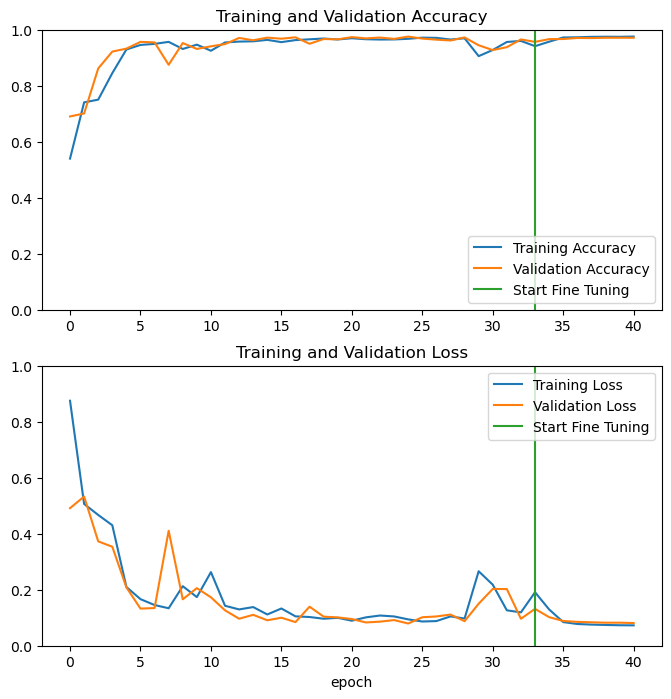

In [110]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Preprocessing data step 11 - Visulization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ANN Prediction example: Class:  1
ANN Prediction example: Class:  2
ANN Prediction example: Class:  3
ResNet Prediction example: Class:  1
ResNet Prediction example: Class:  2
ResNet Prediction example: Class:  3
CNN Prediction example: Class:  1
CNN Prediction example: Class:  2
CNN Prediction example: Class:  3
MobileNet Prediction example: Class:  1
MobileNet Prediction example: Class:  2
MobileNet Prediction example: Class:  3
VGG Prediction example: Class:  1
VGG Prediction example: Class:  2
VGG Prediction example: Class:  3


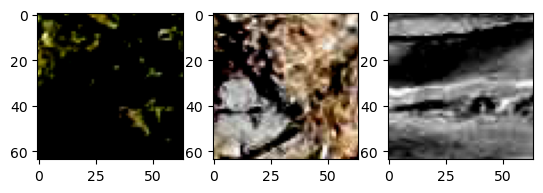

In [115]:

plt.subplot(1, 3, 1) 
plt.imshow(R_val[22,:])
plt.subplot(1, 3, 2) 
plt.imshow(R_val[1,:])
plt.subplot(1, 3, 3) 
plt.imshow(R_val[4,:])
print("ANN Prediction example: Class: ", np.argmax(y_pred_dl_p[22,:]))
print("ANN Prediction example: Class: ", np.argmax(y_pred_dl_p[1,:]))
print("ANN Prediction example: Class: ", np.argmax(y_pred_dl_p[4,:]))
print("ResNet Prediction example: Class: ", np.argmax(y_pred_rn_p[22,:]))
print("ResNet Prediction example: Class: ", np.argmax(y_pred_rn_p[1,:]))
print("ResNet Prediction example: Class: ", np.argmax(y_pred_rn_p[4,:]))
print("CNN Prediction example: Class: ", np.argmax(y_pred_cnn_p[22,:]))
print("CNN Prediction example: Class: ", np.argmax(y_pred_cnn_p[1,:]))
print("CNN Prediction example: Class: ", np.argmax(y_pred_cnn_p[4,:]))
print("MobileNet Prediction example: Class: ", np.argmax(y_pred_mbn_p[22,:]))
print("MobileNet Prediction example: Class: ", np.argmax(y_pred_mbn_p[1,:]))
print("MobileNet Prediction example: Class: ", np.argmax(y_pred_mbn_p[4,:]))
print("VGG Prediction example: Class: ", np.argmax(y_pred_vgg_p[22,:]))
print("VGG Prediction example: Class: ", np.argmax(y_pred_vgg_p[1,:]))
print("VGG Prediction example: Class: ", np.argmax(y_pred_vgg_p[4,:]))

In [116]:
def normalized(data):

    normalizedData = data/np.linalg.norm(data)
    return normalizedData


y_pred_dl_p_2 = simple_model.predict(Z_val)
y_pred_cnn_p_2 = CNNs_model.predict(R_val)
y_pred_rn_p_2 = model_rn.predict(R_val)
y_pred_mbn_p_2 = MobileNetV2_model.predict(R_val)
y_pred_vgg_p_2 = VGG16.predict(R_val)


 2/83 [..............................] - ETA: 5s 

2023-02-20 18:51:38.094874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/83 [>.............................] - ETA: 1s 

2023-02-20 18:51:38.998611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 1s 11ms/step


2023-02-20 18:51:40.533190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 5s 40ms/step


2023-02-20 18:51:45.329065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 2s 17ms/step


2023-02-20 18:51:47.484149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 3s 31ms/step


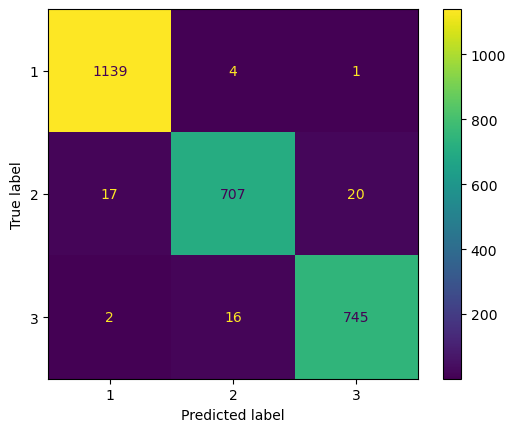

Accuracy Simple Deep Learning model:  0.97736703130894


In [117]:

#fusion"""y
fusion_softmax = normalized(y_pred_dl_p_2) +normalized(y_pred_cnn_p_2) + normalized(y_pred_rn_p_2) + normalized(y_pred_mbn_p_2)+ normalized(y_pred_vgg_p_2)
fusion_label = np.argmax(fusion_softmax,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_val, fusion_label)
plt.show()

acc_dl = accuracy_score(Y_val, fusion_label)
print("Accuracy Simple Deep Learning model: ", acc_dl)